In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import geopandas as gpd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
aqi = pd.read_csv('datasets/annual_aqi_by_county_2020.csv')
aqi.columns = aqi.columns.str.replace(' ', '_').str.lower()
aqi = aqi[~aqi.state.isin(['Country Of Mexico', 'Puerto Rico', 'Virgin Islands'])]
aqi.columns

Index(['state', 'county', 'year', 'days_with_aqi', 'good_days',
       'moderate_days', 'unhealthy_for_sensitive_groups_days',
       'unhealthy_days', 'very_unhealthy_days', 'hazardous_days', 'max_aqi',
       '90th_percentile_aqi', 'median_aqi', 'days_co', 'days_no2',
       'days_ozone', 'days_so2', 'days_pm2.5', 'days_pm10'],
      dtype='object')

# County-level data

## General processing

In [3]:
def county_process(x):
    '''This function simplifies the county names in the two datasets'''
    x = x.str.lower()
    x = x.str.replace(' county', '').str.replace(' census area', '').str.replace(' city and borough', '')
    x = x.str.replace(' borough', '').str.replace(' parish', '').str.replace(' municipality', '')
    x = x.str.replace('saint', 'st').str.replace('. ', ' ', regex=False).str.replace(r'\s$', '', regex=True)
    x = x.str.replace('dona', 'doña').str.replace('la salle', 'lasalle')
    x = x.str.replace('charles city', 'charles').str.replace('(city)', 'city', regex=False)
    return x

In [4]:
# 2020 Census Population (county level)
pop = pd.read_csv('datasets/pop_county_2020.csv')
pop['county'] = county_process(pop['area'].str.split(', ').str[0].astype(str))
pop['state'] = pop['area'].str.split(', ').str[1].astype(str).str.lower()
pop['population'] = pop['population'].str.replace(',', '').astype(int)
pop = pop.drop(columns=['area'])
pop

,population,county,state
0,58805,autauga,alabama
1,231767,baldwin,alabama
2,25223,barbour,alabama
3,22293,bibb,alabama
4,59134,blount,alabama
...,...,...,...
3138,42272,sweetwater,wyoming
3139,23331,teton,wyoming
3140,20450,uinta,wyoming
3141,7685,washakie,wyoming


In [5]:
aqi['county'] = county_process(aqi['county'])
aqi['state'] = aqi['state'].str.lower()
aqi_pll = aqi[['state', 'county', 'days_with_aqi', 'median_aqi', 'days_co', 'days_no2', 'days_ozone', 'days_so2',
               'days_pm2.5', 'days_pm10']].copy()
for pll in ['days_co', 'days_no2', 'days_ozone', 'days_so2', 'days_pm2.5', 'days_pm10']:
    aqi_pll[pll] = aqi_pll[pll] / aqi_pll['days_with_aqi']

aqi_pop = aqi_pll.merge(pop, left_on=['state', 'county'], right_on=['state', 'county'], how='left')
aqi_pop

,state,county,days_with_aqi,median_aqi,days_co,days_no2,days_ozone,days_so2,days_pm2.5,days_pm10,population
0,alabama,baldwin,269,36,0.0,0.000000,0.736059,0.000000,0.263941,0.000000,231767
1,alabama,clay,108,26,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,14236
2,alabama,dekalb,364,36,0.0,0.000000,0.909341,0.000000,0.090659,0.000000,71608
3,alabama,elmore,197,31,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,87977
4,alabama,etowah,278,34,0.0,0.000000,0.733813,0.000000,0.266187,0.000000,103436
...,...,...,...,...,...,...,...,...,...,...,...
1019,wyoming,sublette,366,44,0.0,0.000000,0.969945,0.000000,0.030055,0.000000,8728
1020,wyoming,sweetwater,366,46,0.0,0.013661,0.691257,0.000000,0.019126,0.275956,42272
1021,wyoming,teton,366,42,0.0,0.000000,0.898907,0.000000,0.101093,0.000000,23331
1022,wyoming,uinta,366,40,0.0,0.005464,0.614754,0.000000,0.000000,0.379781,20450


In [6]:
gdp = pd.read_csv('datasets/gdp_state_county_2020.csv', header=None)
gdp.columns = ['area', 'gdp']
gdp['area'] = gdp['area'].str.lower()

nan_row = gdp[gdp['area'].isna()].index.tolist()
state_index = [0] + [i+1 for i in nan_row]
gdp_state = gdp.iloc[state_index].copy()
gdp_state['gdp'] = gdp_state['gdp'].str.replace(',', '').astype(np.int64)

state = pop['state'].unique()
del state_index[8]
gdp_county = gdp.drop(state_index).dropna().query('gdp != "(NA)"').copy()
gdp_county['state'] = 0
num1 = 0
for i, num2 in enumerate(nan_row):
    gdp_county.loc[num1:num2, 'state'] = state[i]
    num1 = num2
gdp_county.loc[num1:, 'state'] = state[i+1]
gdp_county['gdp'] = gdp_county['gdp'].str.replace(',', '').astype(int)
gdp_county.columns = ['county', 'gdp', 'state']
gdp_county['county'] = county_process(gdp_county['county'])

## Manual correction: Virginia and Hawaii
Virginia has many independent cities, which are county-equivalents. The GDP of many independent cities, however, are combined with the GDP of their neighboring counties. We assign GDP to these cities and counties based on their population proportions, i.e., we assume the cities and counties within a single combined area have the same GDP per capita (which is biased but practicable). In addition, the inconsistence in city and county naming also needs to be addressed.

Similarly, Hawaii combined the GDP of Maui county and Kalawao county.

In [7]:
va = gdp_county.query('state == "virginia"')
va1 = va[va['county'].isin(['hampton', 'norfolk', 'richmond', 'suffolk', 'virginia beach'])].copy()
va1['county'] = va1['county'] + ' city'
gdp_county = pd.concat([gdp_county, va1])

va2 = va.tail(23).copy()
lst = va2['county'].str.split('\s\+\s', regex=True)
lst0 = lst.str[0].str.split(', ')
lst1_id, lst1 = list(lst.str[1].index), list(lst.str[1])
lst2_id, lst2 = list(lst0.str[0].index), list(lst0.str[0])
lst3_id, lst3 = list(lst0.str[1].index), list(lst0.str[1])

va_split = pd.DataFrame(lst1+lst2+lst3, columns=['county'])
va_split['index'] = lst1_id + lst2_id + lst3_id
va_split['state'] = 'virginia'
va_split = va_split.dropna().merge(pop, left_on=['state', 'county'], right_on=['state', 'county'], how='left')
va_nan = va_split[va_split['population'].isna()][['county', 'index', 'state']].copy()
va_nan['county'] = va_nan['county'] + ' city'
va_nan = va_nan.merge(pop, left_on=['state', 'county'], right_on=['state', 'county'], how='left')

va_new = pd.concat([va_split[~va_split['population'].isna()], va_nan])
va_new['population'] = va_new['population'].astype(int)
va_total = va['gdp'].reset_index()
va_gdp = va_new.merge(va_total, left_on='index', right_on='index', how='left').sort_values(by='gdp', ascending=False)
va_gdp['gdp'] = (va_gdp.groupby('gdp')['population'].apply(lambda x: x/sum(x)) * va_gdp['gdp']).astype(int)
va_gdp = va_gdp[['county', 'gdp', 'state']]
gdp_county = pd.concat([gdp_county, va_gdp])

In [8]:
hi_split = pd.DataFrame(['maui', 'kalawao'], columns=['county'])
hi_split['state'] = 'hawaii'
hi_gdp = hi_split.merge(pop, left_on=['state', 'county'], right_on=['state', 'county'], how='left') 
hi_gdp['gdp'] = gdp_county.query('state == "hawaii" and county == "maui + kalawao"')['gdp'].values[0]
hi_gdp['gdp'] = (hi_gdp.groupby('state')['population'].apply(lambda x: x/sum(x)) * hi_gdp['gdp']).astype(int)
hi_gdp = hi_gdp[['county', 'gdp', 'state']]
gdp_county = pd.concat([gdp_county, hi_gdp])

In [9]:
aqi_pop_gdp = aqi_pop.merge(gdp_county, left_on=['state', 'county'], right_on=['state', 'county'], how='left')
sum(aqi_pop_gdp['gdp'].isna())

0

In [10]:
states = gpd.read_file('datasets/cb_2018_us_state_500k.shp').to_crs(2163)
states['NAME'] = states['NAME'].str.lower()
states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((1109990.968 -1565553.473, 1111..."
1,37,01027616,0400000US37,37,NC,north carolina,00,125923656064,13466071395,"MULTIPOLYGON (((2154835.730 -692236.318, 21554..."
2,40,01102857,0400000US40,40,OK,oklahoma,00,177662925723,3374587997,"POLYGON ((-268956.153 -936541.911, -268644.290..."
3,51,01779803,0400000US51,51,VA,virginia,00,102257717110,8528531774,"MULTIPOLYGON (((2098181.788 -490386.322, 20982..."
4,54,01779805,0400000US54,54,WV,west virginia,00,62266474513,489028543,"POLYGON ((1506493.502 -601384.449, 1506500.488..."


In [11]:
state_map = states[['NAME', 'STUSPS']].rename(columns={'NAME': 'state', 'STUSPS': 'state_code'})

In [12]:
temp = pd.read_csv('datasets/tavg_county_2020.csv')
temp['state_code'] = temp['area'].str.split('-').str[0]
temp['county'] = county_process(temp['county'])
temp = temp.merge(state_map, left_on='state_code', right_on='state_code', how='left')

rain = pd.read_csv('datasets/pcp_county_2020.csv')
rain['state_code'] = rain['area'].str.split('-').str[0]
rain['county'] = county_process(rain['county'])
rain = rain.merge(state_map, left_on='state_code', right_on='state_code', how='left')

In [13]:
clmt = temp.merge(rain, left_on=['area', 'state', 'state_code', 'county'], right_on=['area', 'state', 'state_code', 'county'], how='left')

In [14]:
contl = aqi_pop_gdp.query('state not in ["hawaii", "district of columbia"]')
AQI = contl.merge(clmt[['state', 'county', 'temperature', 'precipitation']], left_on=['state', 'county'],
                  right_on=['state', 'county'], how='left')
AQI

,state,county,days_with_aqi,median_aqi,days_co,days_no2,days_ozone,days_so2,days_pm2.5,days_pm10,population,gdp,temperature,precipitation
0,alabama,baldwin,269,36,0.0,0.000000,0.736059,0.000000,0.263941,0.000000,231767,6985901,68.8,63.27
1,alabama,clay,108,26,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,14236,407934,62.5,76.01
2,alabama,dekalb,364,36,0.0,0.000000,0.909341,0.000000,0.090659,0.000000,71608,1777822,60.4,73.81
3,alabama,elmore,197,31,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,87977,1709154,65.9,70.94
4,alabama,etowah,278,34,0.0,0.000000,0.733813,0.000000,0.266187,0.000000,103436,2563314,62.6,71.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016,wyoming,sublette,366,44,0.0,0.000000,0.969945,0.000000,0.030055,0.000000,8728,1620688,36.0,14.99
1017,wyoming,sweetwater,366,46,0.0,0.013661,0.691257,0.000000,0.019126,0.275956,42272,3278745,42.2,6.30
1018,wyoming,teton,366,42,0.0,0.000000,0.898907,0.000000,0.101093,0.000000,23331,2175642,35.4,33.82
1019,wyoming,uinta,366,40,0.0,0.005464,0.614754,0.000000,0.000000,0.379781,20450,790528,40.5,7.85


In [15]:
sum(AQI['temperature'].isna())

0

## Linear Regression

In [16]:
AQI['log_gdp'] = np.log(AQI['gdp'])
AQI['pop/1e6'] = AQI['population'] / 1e6

y = AQI['median_aqi']
X = AQI[['log_gdp', 'pop/1e6', 'temperature', 'precipitation']]
# X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             median_aqi   R-squared (uncentered):                   0.909
Model:                            OLS   Adj. R-squared (uncentered):              0.908
Method:                 Least Squares   F-statistic:                              2534.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):                        0.00
Time:                        22:18:35   Log-Likelihood:                         -3866.3
No. Observations:                1021   AIC:                                      7741.
Df Residuals:                    1017   BIC:                                      7760.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
log_gdp           1.6496      0.139     11.883      0.000       1.377       1.922
pop/1e6           4.5672      0.641      7.126      0.000       3.310       5.825
temperature       0.2057      0.040      5.167      0.000       0.128       0.284
precipitation    -0.1092      0.017     -6.307      0.000      -0.143      -0.075
==============================================================================
Omnibus:                      148.706   Durbin-Watson:                   1.705
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1562.892
Skew:                          -0.256   Prob(JB):                         0.00
Kurtosis:                       9.040   Cond. No.                         139.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## PCA & $k$-means: Counties of focus

### By population

In [17]:
aqi_met = aqi_pop_gdp.query('state != "district of columbia"')[['state', 'county', 'population']]
aqi_met = aqi_met.sort_values(by='population', ascending=False).head(30)
met_state, met_county = aqi_met['state'].values, aqi_met['county'].values

In [18]:
daily = pd.read_csv('datasets/daily_aqi_by_county_2020.csv')
daily.columns = daily.columns.str.replace(' ', '_').str.lower()
daily['state'] = daily['state_name'].str.lower()
daily['county'] = county_process(daily['county_name'])
date_split = daily['date'].str.split('-')
daily['month'] = date_split.str[1].astype(int)
daily['day'] = date_split.str[2].astype(int)

met_list = []
for i in range(30):
    monthly = daily[(daily['state'] == met_state[i]) & (daily['county'] == met_county[i])]
    monthly_aqi = monthly.groupby(['state', 'county', 'month'])['aqi'].agg('mean').values
    met_list.append(monthly_aqi)

In [19]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
heat = pd.DataFrame(met_list, columns=months)
heat['state'], heat['county'] = met_state, met_county
heat = heat.merge(state_map, left_on='state', right_on='state', how='left')
heat['County'] = heat['county'].str.title() + ', ' + heat['state_code']
heat = heat.set_index('County')[months]

<AxesSubplot:ylabel='County'>

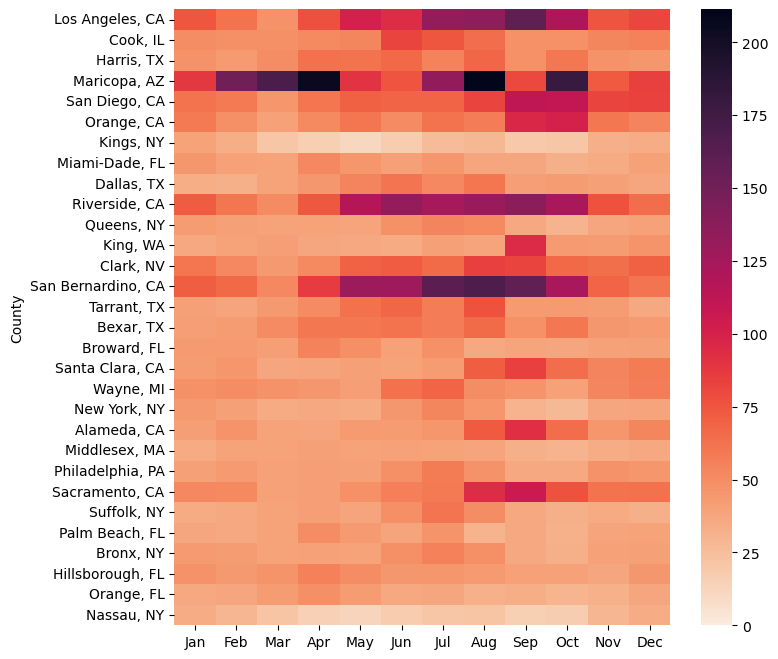

In [20]:
fig = plt.figure(figsize=(8, 8))
sns.heatmap(heat, vmin=0, vmax=heat.max().max(), cmap='rocket_r')
# plt.savefig('figures/heatmap.png', dpi=200, bbox_inches='tight')

In [21]:
pca = PCA(whiten=True)
pca.fit(heat)
met_t = pd.DataFrame(pca.transform(heat)[:, :2], columns=['PC1', 'PC2'])
var = pca.explained_variance_ratio_

kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(met_t)
met_t['cluster'] = kmeans.labels_
met_t['county'] = heat.index

C:\Users\Fsq\anaconda3\envs\geo\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(-0.4997312663674176, 0.8108170147848623, 'East Coast')

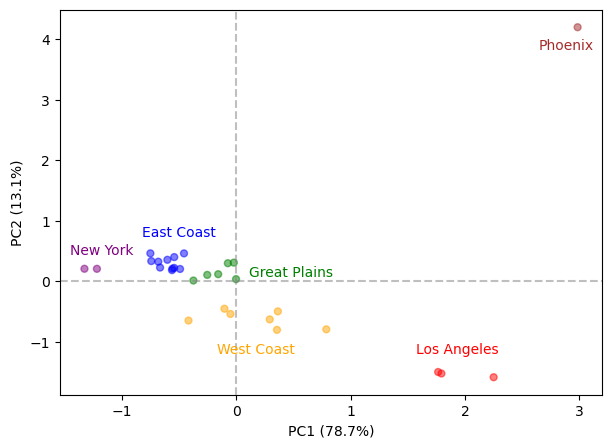

In [22]:
color = {0: 'purple', 1: 'red', 2: 'brown', 3: 'green', 4: 'orange', 5: 'blue'}
label_color = [color[i] for i in kmeans.labels_]
center = kmeans.cluster_centers_

fig = plt.figure(figsize=(7, 5))
plt.scatter(met_t['PC1'], met_t['PC2'], color=label_color, marker='o', s=25, alpha=.5)
plt.xlabel(f'PC1 ({100*var[0]:.1f}%)')
plt.ylabel(f'PC2 ({100*var[1]:.1f}%)')
plt.axhline(0, color='gray', ls='--', alpha=.5)
plt.axvline(0, color='gray', ls='--', alpha=.5)
plt.annotate('New York', (center[0][0]+.1, center[0][1]+.3), ha='center', va='center', color=color[0])
plt.annotate('Los Angeles', (center[1][0], center[1][1]+.4), ha='center', va='center', color=color[1])
plt.annotate('Phoenix', (center[2][0]-.1, center[2][1]-.3), ha='center', va='center', color=color[2])
plt.annotate('Great Plains', (center[3][0]+.63, center[3][1]), ha='center', va='center', color=color[3])
plt.annotate('West Coast', (center[4][0], center[4][1]-.5), ha='center', va='center', color=color[4])
plt.annotate('East Coast', (center[5][0]+.1, center[5][1]+.5), ha='center', va='center', color=color[5])
# plt.savefig('figures/pca1.png', dpi=200, bbox_inches='tight')

### By GDP per capita & population

In [23]:
aqi_rich = aqi_pop_gdp.query('population >= 5e4 and state != "district of columbia"')[['state', 'county', 'population', 'gdp']].copy()
# GDP per capita (k$) = GDP (k$) / population
aqi_rich['gdp_pc'] = aqi_rich['gdp'] / aqi_rich['population']
aqi_rich = aqi_rich.sort_values(by='gdp_pc', ascending=False).head(30)
rich_state, rich_county = aqi_rich['state'].values, aqi_rich['county'].values

In [24]:
rich_list = []
for i in range(30):
    monthly = daily[(daily['state'] == rich_state[i]) & (daily['county'] == rich_county[i])]
    monthly_aqi = monthly.groupby(['state', 'county', 'month'])['aqi'].agg('mean').values
    rich_list.append(monthly_aqi)

heat2 = pd.DataFrame(rich_list, columns=months)
heat2['state'], heat2['county'] = rich_state, rich_county
heat2 = heat2.merge(state_map, left_on='state', right_on='state', how='left')
heat2.loc[heat2['county'] == 'st louis city', 'county'] = 'st. louis city'
heat2.loc[heat2['county'] == 'st charles', 'county'] = 'st. charles'
heat2['County or equivalent'] = heat2['county'].str.title() + ', ' + heat2['state_code']
heat2 = heat2.set_index('County or equivalent')[months]

<AxesSubplot:ylabel='County or equivalent'>

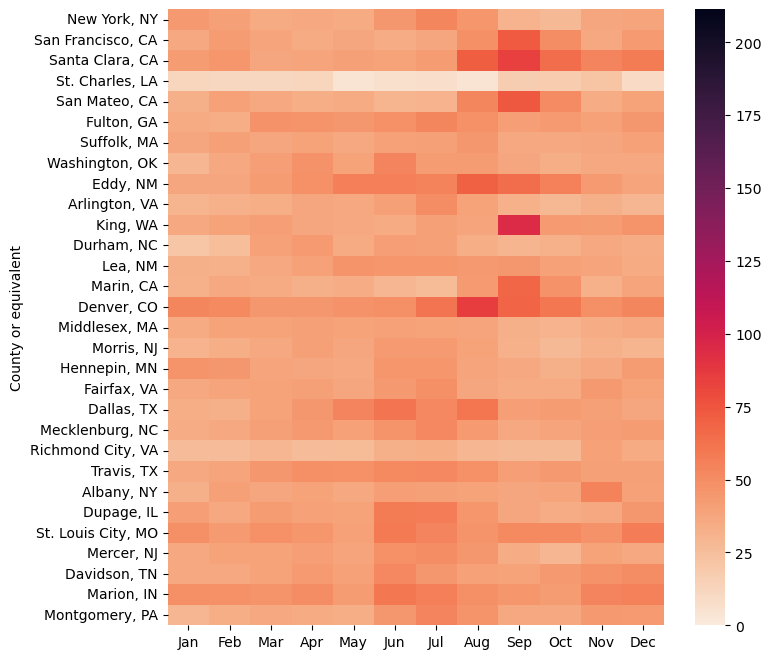

In [25]:
fig = plt.figure(figsize=(8, 8))
sns.heatmap(heat2, vmin=0, vmax=heat.max().max(), cmap='rocket_r')
# plt.savefig('figures/heatmap2.png', dpi=200, bbox_inches='tight')

In [26]:
pca2 = PCA(whiten=True)
pca2.fit(heat2)
rich_t = pd.DataFrame(pca2.transform(heat2)[:, :2], columns=['PC1', 'PC2'])
var2 = pca2.explained_variance_ratio_

kmeans2 = KMeans(n_clusters=4, random_state=42)
kmeans2.fit(rich_t)
rich_t['cluster'] = kmeans2.labels_
rich_t['county'] = heat2.index

C:\Users\Fsq\anaconda3\envs\geo\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(-1.3263771396087594, -0.294275031786584, 'Middle West')

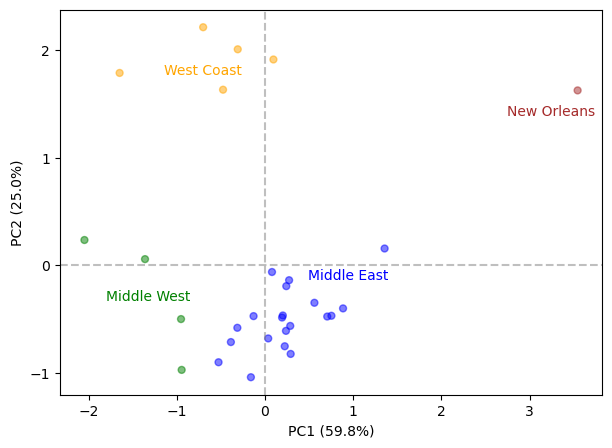

In [27]:
color = {0: 'orange', 1: 'blue', 2: 'brown', 3: 'green', 4: 'red', 5: 'purple'}
label_color2 = [color[i] for i in kmeans2.labels_]
center2 = kmeans2.cluster_centers_

fig = plt.figure(figsize=(7, 5))
plt.scatter(rich_t['PC1'], rich_t['PC2'], color=label_color2, marker='o', s=25, alpha=.5)
plt.xlabel(f'PC1 ({100*var2[0]:.1f}%)')
plt.ylabel(f'PC2 ({100*var2[1]:.1f}%)')
plt.yticks([-1, 0, 1, 2])
plt.axhline(0, color='gray', ls='--', alpha=.5)
plt.axvline(0, color='gray', ls='--', alpha=.5)
plt.annotate('West Coast', (center2[0][0]-.1, center2[0][1]-.1), ha='center', va='center', color=color[0])
plt.annotate('Middle East', (center2[1][0]+.7, center2[1][1]+.4), ha='center', va='center', color=color[1])
plt.annotate('New Orleans', (center2[2][0]-.3, center2[2][1]-.2), ha='center', va='center', color=color[2])
plt.annotate('Middle West', (center2[3][0], center2[3][1]), ha='center', va='center', color=color[3])
# plt.savefig('figures/pca2.png', dpi=200, bbox_inches='tight')

# State-level data

## General processing
The state-level AQI data are populated-weighted averages of the county-level AQI data.

In [28]:
def avg_pll(df, pll):
    '''This function shortens the expression in df.groupby.apply()'''
    return np.average(df[pll], weights=df['population'])

In [29]:
aqi_state = aqi_pop.groupby('state').apply(lambda x: pd.Series([avg_pll(x, 'median_aqi'), avg_pll(x, 'days_co'), avg_pll(x, 'days_no2'),
                                                                avg_pll(x, 'days_ozone'), avg_pll(x, 'days_so2'), avg_pll(x, 'days_pm2.5'),
                                                                avg_pll(x, 'days_pm10')], 
                                                               index=['median_aqi', 'days_co', 'days_no2', 'days_ozone', 'days_so2',
                                                                      'days_pm2.5', 'days_pm10']))

In [30]:
states = states[states['NAME'].isin([s for s in state])]
states = states.merge(aqi_state, left_on='NAME', right_on='state', how='left')

In [31]:
us = states[states['NAME'].isin([s for s in state])]
us.loc[us['NAME'] == 'alaska', 'geometry'] = us.loc[us['NAME'] == 'alaska', 'geometry'].scale(.4, .4, origin=(1.1e5, -5.1e6))
us.loc[us['NAME'] == 'hawaii', 'geometry'] = us.loc[us['NAME'] == 'hawaii', 'geometry'].scale(.8, .8, origin=(1.3e7, -6e6))
us.loc[us['NAME'] == 'maryland', 'STUSPS'] = ''
us.loc[us['NAME'] == 'district of columbia', 'STUSPS'] = 'MD\nDC'
us.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,median_aqi,days_co,days_no2,days_ozone,days_so2,days_pm2.5,days_pm10
0,28,01779790,0400000US28,28,MS,mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((1109990.968 -1565553.473, 1111...",39.088459,0.000000,0.002251,0.413310,0.000000,0.584439,0.000000
1,37,01027616,0400000US37,37,NC,north carolina,00,125923656064,13466071395,"MULTIPOLYGON (((2154835.730 -692236.318, 21554...",34.880480,0.000477,0.002391,0.532231,0.039811,0.418784,0.006306
2,40,01102857,0400000US40,40,OK,oklahoma,00,177662925723,3374587997,"POLYGON ((-268956.153 -936541.911, -268644.290...",39.647062,0.000021,0.011505,0.532466,0.052732,0.397737,0.005540
3,51,01779803,0400000US51,51,VA,virginia,00,102257717110,8528531774,"MULTIPOLYGON (((2098181.788 -490386.322, 20982...",31.622849,0.002067,0.079122,0.556856,0.008462,0.337917,0.015576
4,54,01779805,0400000US54,54,WV,west virginia,00,62266474513,489028543,"POLYGON ((1506493.502 -601384.449, 1506500.488...",30.668994,0.000000,0.000000,0.548914,0.141604,0.299401,0.010081


## Spatial patterns

In [32]:
def plot_pll(column):
    fig = plt.figure(1, figsize=(12, 8))
    ax = fig.add_subplot()
    ax.axis('off')
    us.apply(lambda x: ax.annotate(text=x['STUSPS'], xy=x['geometry'].centroid.coords[0], ha='center', va='center', fontsize=8), axis=1)
    us.boundary.plot(ax=ax, linewidth=.5, color='gray')
    us.plot(ax=ax, column=column, cmap='YlOrRd', legend=True, alpha=.8, legend_kwds={'shrink': .5, 'alpha': .8})

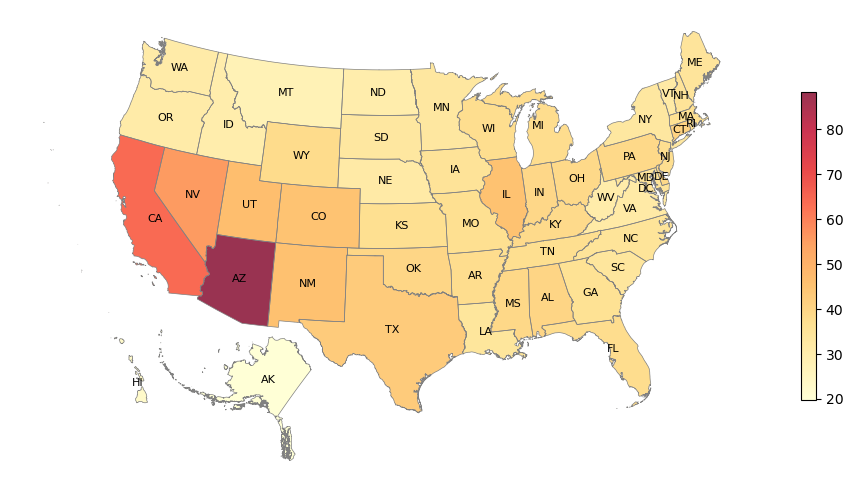

In [33]:
plot_pll('median_aqi')
# plt.savefig('figures/aqi.png', dpi=200, bbox_inches='tight')

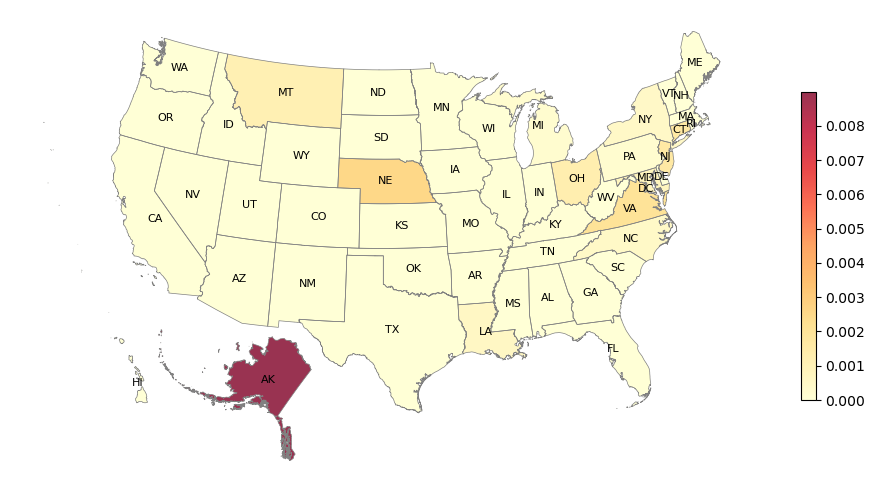

In [34]:
plot_pll('days_co')
# plt.savefig('figures/co.png', dpi=200, bbox_inches='tight')

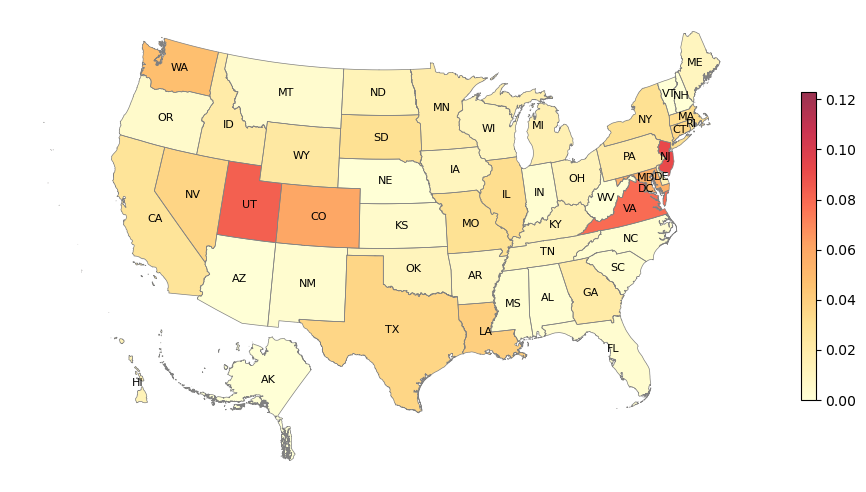

In [35]:
plot_pll('days_no2')
# plt.savefig('figures/no2.png', dpi=200, bbox_inches='tight')

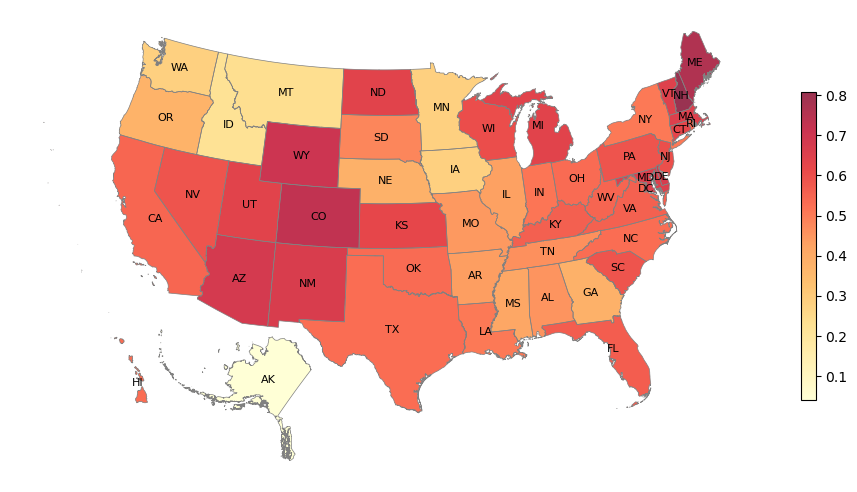

In [36]:
plot_pll('days_ozone')
# plt.savefig('figures/ozone.png', dpi=200, bbox_inches='tight')

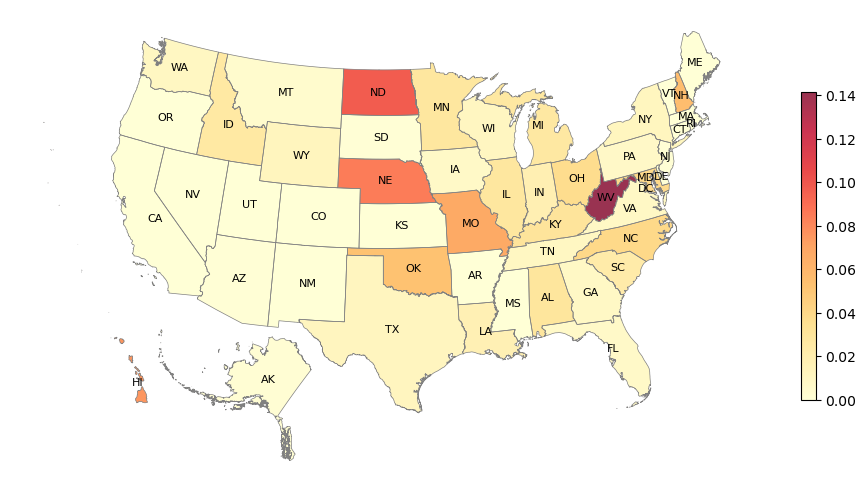

In [37]:
plot_pll('days_so2')
# plt.savefig('figures/so2.png', dpi=200, bbox_inches='tight')

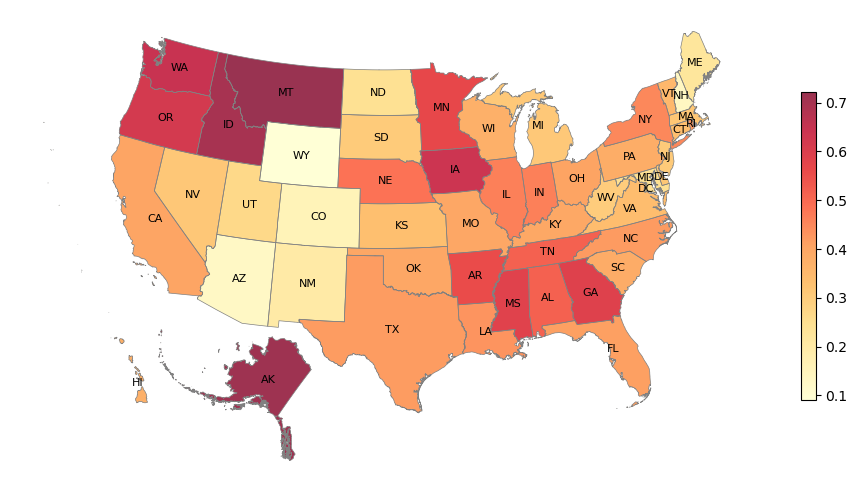

In [38]:
plot_pll('days_pm2.5')
# plt.savefig('figures/pm25.png', dpi=200, bbox_inches='tight')

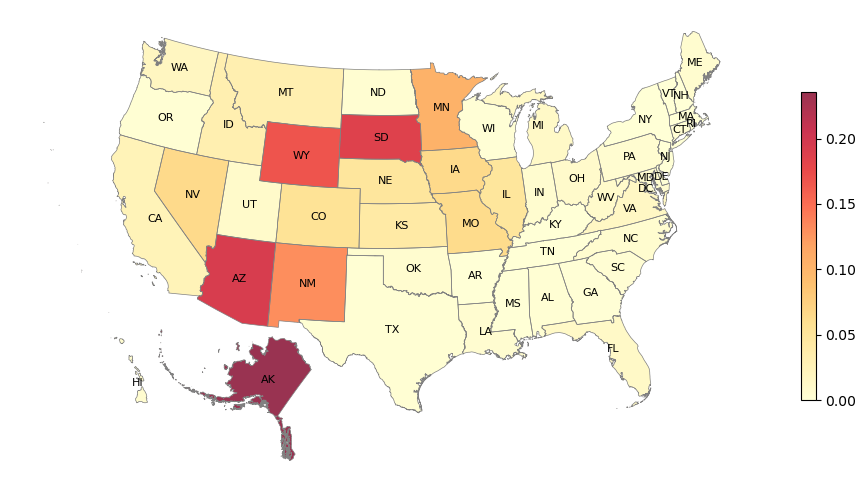

In [39]:
plot_pll('days_pm10')
# plt.savefig('figures/pm10.png', dpi=200, bbox_inches='tight')